In [1]:
import sys
sys.path.append("../")

In [2]:
from utils.common_train_utils import *
from utils.draw_candle_image import *
from utils.evaluate_old_models import *
from functools import partial
from model_code import *
from ta import add_all_ta_features
from ta.utils import dropna
import json
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import shutil
import ta
import ta.momentum
import ta.trend
import tempfile
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import inspect
import random

In [3]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [4]:
print(logdir)

C:\Users\ADMIN\AppData\Local\Temp\tmpi93f5sxx\tensorboard_logs


In [5]:
symbol = input("symbol = ").strip().lower()

In [6]:
dataset_folder = f"../dataset/{symbol}_with_ema_macd_trend"

In [7]:
config = read_config(dataset_folder)
candle_type_and_directory_save: dict = config["candle_type_and_directory_save"]
previous_days = config["previous_days"]
next_days = config["next_days"]
days_result = config["days_result"]

In [8]:
dataset_test = load_dataset_of_each_type_and_combine(f"{dataset_folder}/test", candle_type_and_directory_save)
total_data_test = len(dataset_test)

In [9]:
dataset_train = load_dataset_of_each_type_and_combine(f"{dataset_folder}/train", candle_type_and_directory_save)
total_data_train = len(dataset_train)

In [10]:
dataset_train

<_ConcatenateDataset element_spec=(TensorSpec(shape=(6, 1), dtype=tf.float64, name=None), TensorSpec(shape=(6, 1), dtype=tf.float64, name=None), TensorSpec(shape=(1,), dtype=tf.int32, name=None), TensorSpec(shape=(287, 287, 3), dtype=tf.float64, name=None), TensorSpec(shape=(6, 4), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [11]:
def channels_to_time_step_attention_ema_macd_trend(image_shape, days_result, days_of_ema_9=2, days_of_macd_history=2):

    # Hàm Attention
    def attention_3d_block(inputs):
        # inputs.shape = (batch_sizes, time_steps=days_result, features=lstm_units)
        time_steps = inputs.shape[1]
        
        a = keras.layers.Permute((2, 1))(inputs)  # (batch_sizes, features=lstm_units, time_steps=days_result)
        
        # Tính attention score: (batch_sizes, features=lstm_units, time_steps=days_result)
        # Softmax áp dụng trên axis cuối
        a = keras.layers.Dense(time_steps, activation='softmax')(a)  
        
        # Trả về attention score theo thứ tự: (batch_sizes, time_steps=days_result, features=lstm_units)
        a_probs = keras.layers.Permute((2, 1))(a)  
        
        # Tính trọng số của inputs với attention score: (batch_sizes, time_steps=days_result, features=lstm_units)
        output_attention_mul = keras.layers.Multiply()([inputs, a_probs])  
        
        return output_attention_mul

    trend_type_input = keras.layers.Input(shape=(1,), name="trend_type_input")
    x1 = keras.layers.Dense(8, activation='relu')(trend_type_input)
    x1 = keras.layers.RepeatVector(days_result)(x1) # (batch_size, days_result, 8)
    
    ema_9_input = keras.layers.Input(shape=(days_of_ema_9,), name="ema_9_input")
    x3 = keras.layers.Dense(8, activation='relu')(ema_9_input)
    x3 = keras.layers.RepeatVector(days_result)(x3) # (batch_size, days_result, 8)
    
    macd_history_input = keras.layers.Input(shape=(days_of_macd_history,), name="macd_history_input")
    x4 = keras.layers.Dense(8, activation='relu')(macd_history_input)
    x4 = keras.layers.RepeatVector(days_result)(x4) # (batch_size, days_result, 8)
    
    image_input = keras.layers.Input(shape=image_shape, name="image_input") # (batch_size, height, width, channels)
    x2 = keras.layers.Conv2D(8, (2, 2), strides=1, activation='relu')(image_input) # (batch_size, height, width, channels=8)
    x2 = keras.layers.Conv2D(days_result, (2, 2), activation='relu')(x2) # (batch_size, height, width, channels=days_result)
    x2 = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x2)

    x2 = keras.layers.Permute((3, 1, 2))(x2) # (batch_size, channels, height, width)
    x2 = keras.layers.TimeDistributed(keras.layers.Flatten())(x2)
    x2 = keras.layers.TimeDistributed(keras.layers.Dense(64, activation='relu'))(x2)
    x2 = keras.layers.TimeDistributed(keras.layers.Dropout(0.1))(x2) # (batch_size, days_result, 64)
    
    x = keras.layers.concatenate([x3, x4, x1, x2], axis=-1)
    x = keras.layers.TimeDistributed(keras.layers.Dense(64, activation='relu'))(x)
    x = keras.layers.TimeDistributed(keras.layers.Dropout(0.1))(x)
    x = keras.layers.TimeDistributed(keras.layers.Dense(64, activation='relu'))(x)
    
    # LSTM với Attention
    lstm = keras.layers.Bidirectional(keras.layers.LSTM(128, activation="relu", return_sequences=True))(x)
    lstm = keras.layers.Dropout(0.1)(lstm)
    lstm = keras.layers.Bidirectional(keras.layers.LSTM(128, activation="relu", return_sequences=True))(lstm)
    lstm_out = keras.layers.Dropout(0.1)(lstm) # (batch_sizes, time_steps=days_result, features=lstm_units)
    
    # Áp dụng Attention: (batch_sizes, time_steps=days_result, features=lstm_units)
    attention_mul = attention_3d_block(lstm_out)
    
    # Lớp đầu ra
    output = keras.layers.TimeDistributed(keras.layers.Dense(2, activation='linear'))(attention_mul)
    
    # Xây dựng mô hình
    model = keras.models.Model(inputs=[ema_9_input, macd_history_input, trend_type_input, image_input], outputs=output)
    
    return model, "channels_to_time_step_attention_ema_macd_trend"


In [12]:
function_transform_origin = get_open_close_prices_percent_of_last_days_result_for_ema_macd_trend_dataset
model_function = channels_to_time_step_attention_ema_macd_trend
function_evaluate_old_model = evaluate_fpt_model_5_biLSTM_with_trend_type_2023_2024
image_shape = get_image_shape(dataset_train, index_of_image=3)
model, model_name = model_function(image_shape, days_result)

In [13]:
# batch_size = 2**int(input("batch_size = 2^x, x = ").strip())
batch_size = int(input("batch_size = ").strip())
STEPS_PER_EPOCH = total_data_train // batch_size + 1
name_sub_folder_save_metrics = f"{model_name}_{os.path.basename(dataset_folder)}"
name_folder_save_metrics = f"sizes/{model_name}_{os.path.basename(dataset_folder)}"
max_epochs = int(input(f"max_epochs = "))
metric_mae_name = "mae"
metric_mae_object = keras.metrics.MeanAbsoluteError(name=metric_mae_name)
metric_mse_name = "mse"
metric_mse_object = keras.metrics.MeanSquaredError(name=metric_mse_name)
val_loss_metric_mae_to_stop = float(input("val_loss_metric_mae_to_stop = "))
val_loss_metric_mse_to_stop = float(input("val_loss_metric_mse_to_stop = "))
start_learning_rate = float(input("start_learning_rate = ").strip())
shuffle_buffer = 300
number_epochs_to_decrease_lr = int(input("number_epochs_to_decrease_lr = "))
number_epochs_to_wait = int(input("number_epochs_to_wait = "))

In [14]:
print(f"2^{np.log2(batch_size)}")
print(f"{batch_size=}")
print(f"{max_epochs=}")
print(f"{start_learning_rate=}")
print(f"{STEPS_PER_EPOCH=}")
print(f"{val_loss_metric_mae_to_stop=}")
print(f"{val_loss_metric_mse_to_stop=}")
print(f"{number_epochs_to_decrease_lr=}")
print(f"{number_epochs_to_wait=}")

2^3.169925001442312
batch_size=9
max_epochs=100
start_learning_rate=0.01
STEPS_PER_EPOCH=292
val_loss_metric_mae_to_stop=-1.0
val_loss_metric_mse_to_stop=-1.0
number_epochs_to_decrease_lr=10
number_epochs_to_wait=10


In [15]:
model_name

'channels_to_time_step_attention_ema_macd_trend'

In [16]:
(total_data_train, total_data_test)

(2619, 54)

In [17]:
dataset_train_1 = dataset_train.shuffle(shuffle_buffer)
dataset_test_1 = dataset_test.shuffle(shuffle_buffer)

dataset_train_2 = dataset_train_1.batch(batch_size)
dataset_test_2 = dataset_test_1.batch(batch_size)

transform_function = partial(function_transform_origin, days_result)
dataset_train_3 = dataset_train_2.map(transform_function)
dataset_test_3 = dataset_test_2.map(transform_function)

In [18]:
# for features, labels in dataset_train_3.take(1):
#     print(features[0].shape)
#     print(features[1].shape)
#     print(labels.shape)

In [19]:
(len(dataset_train_3), len(dataset_test_3))

(291, 6)

In [20]:
class StopAtLossValue(keras.callbacks.Callback):
    def __init__(self, target_loss, metric_name):
        super(StopAtLossValue, self).__init__()
        self.target_loss = target_loss
        self.metric_name = metric_name

    def on_epoch_end(self, epoch, logs=None):
        # Lấy giá trị loss từ logs
        current_loss = logs.get(f"val_{self.metric_name}")
        if current_loss is not None and current_loss <= self.target_loss:
            print(f"\nĐạt target loss = {self.target_loss}, dừng training tại epoch {epoch + 1}")
            self.model.stop_training = True


class SaveModelCallback(keras.callbacks.Callback):
    def __init__(self, save_path):
        super().__init__()
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        # Tạo tên file với số epoch
        folder_tmp = f"{self.save_path}/tmp_model"
        file_name = f"{folder_tmp}/model_tmp_{epoch}.keras"
        self.model.save(file_name)  # Lưu toàn bộ model
        

class TrackingLossCallback(keras.callbacks.Callback):
    def __init__(self, metric_name):
        super().__init__()
        self.list_epochs = []
        self.list_val_loss = []
        self.list_train_loss = []
        self.metric_name = metric_name
        self.val_loss_key = f"val_{self.metric_name}"
        self.train_loss_key = f"{self.metric_name}"

    def on_epoch_end(self, epoch, logs=None):
        # Tạo tên file với số epoch
        self.list_epochs.append(epoch)
        self.list_val_loss.append(logs.get(self.val_loss_key))
        self.list_train_loss.append(logs.get(self.train_loss_key))
    
    def get_df_result(self):
        df = pd.DataFrame({
            "epoch": self.list_epochs,
            self.val_loss_key: self.list_val_loss,
            self.train_loss_key: self.list_train_loss
        })
        df.sort_values(self.val_loss_key, inplace=True)
        return df

In [21]:
def get_optimizer(start_learning_rate, number_epochs_to_decrease_lr):
    lr_schedule = keras.optimizers.schedules.InverseTimeDecay(
        start_learning_rate,
        decay_steps=STEPS_PER_EPOCH*number_epochs_to_decrease_lr,
        decay_rate=1,
        staircase=False
    )
    
    return keras.optimizers.Adam(lr_schedule)

tracking_loss_callback = TrackingLossCallback(metric_mse_name)
def get_callbacks(name, metric_name, number_epochs_to_wait):
    return [
        tfdocs.modeling.EpochDots(),
        StopAtLossValue(val_loss_metric_mae_to_stop, metric_mae_name),
        StopAtLossValue(val_loss_metric_mse_to_stop, metric_mse_name),
        SaveModelCallback(dataset_folder),
        tracking_loss_callback,
        keras.callbacks.EarlyStopping(monitor=f'val_loss', patience=number_epochs_to_wait),
        keras.callbacks.TensorBoard(logdir/name)
    ]
  
  
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=get_optimizer(start_learning_rate, number_epochs_to_decrease_lr),
    metrics=[
        metric_mae_object,
        metric_mse_object
    ],
)


In [22]:
# Ví dụ
all_models_folder_path = os.path.join(os.path.abspath(dataset_folder), "model_save")
evaluate_all_models_in_dataset_folder(
    all_models_folder_path, 
    dataset_test_2,
    days_result
)

,model_name,mse,mae


In [23]:
is_start_train = input("Start train? (y/n): ").lower()[0] == "y"
if is_start_train:
    folder_tmp = f"{dataset_folder}/tmp_model"
    os.makedirs(folder_tmp, exist_ok=False)
    history = model.fit(
        dataset_train_3, 
        validation_data=dataset_test_3,
        epochs=max_epochs, 
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=get_callbacks(name_folder_save_metrics, metric_mse_name, number_epochs_to_wait)
    )

Epoch 1/100


d:\code\selenium\.venv\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['ema_9_input', 'macd_history_input', 'trend_type_input', 'image_input']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(


290/292 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 3.3301 - mae: 1.2167 - mse: 3.3301

C:\Users\ADMIN\AppData\Local\Programs\Python\Python39\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch: 0, loss:3.4712,  mae:1.2361,  mse:3.4712,  val_loss:1.1080,  val_mae:0.7528,  val_mse:1.1080,  
292/292 ━━━━━━━━━━━━━━━━━━━━ 24s 57ms/step - loss: 3.3310 - mae: 1.2169 - mse: 3.3310 - val_loss: 1.1080 - val_mae: 0.7528 - val_mse: 1.1080
Epoch 2/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - loss: 3.3910 - mae: 1.2325 - mse: 3.3910 - val_loss: 1.1450 - val_mae: 0.7483 - val_mse: 1.1450
Epoch 3/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - loss: 3.4016 - mae: 1.2280 - mse: 3.4016 - val_loss: 1.0142 - val_mae: 0.7226 - val_mse: 1.0142
Epoch 4/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - loss: 3.1777 - mae: 1.2015 - mse: 3.1777 - val_loss: 1.0339 - val_mae: 0.7383 - val_mse: 1.0339
Epoch 5/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - loss: 3.2024 - mae: 1.2049 - mse: 3.2024 - val_loss: 0.9495 - val_mae: 0.7001 - val_mse: 0.9495
Epoch 6/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 27s 92ms/step - loss: 3.1822 - mae: 1.1971 - mse: 3.1822 - val_loss: 0.9035 - val_mae: 0.6885 - val_ms

In [24]:
loss = model.evaluate(dataset_test_3, verbose=2)

6/6 - 1s - 100ms/step - loss: 0.9166 - mae: 0.6916 - mse: 0.9166


In [25]:
loss

[0.9165915846824646, 0.6916269659996033, 0.9165915846824646]

In [26]:
def get_folder_path_to_save_model(model_name):
    new_model_name = model_name
    path_save = f"{dataset_folder}/model_save/{new_model_name}"
    while os.path.exists(path_save):
        print(f"-- {path_save} already exists")
        random_index = random.randint(0, 100)
        new_model_name = new_model_name + f"_{random_index}"
        path_save = f"{dataset_folder}/model_save/{new_model_name}"
        print(f"-- Change to {path_save}")
    os.makedirs(path_save, exist_ok=False)
    return path_save, new_model_name 

In [27]:
def save_model(model: keras.Sequential, folder_path, new_model_name):
    path_save = f"{folder_path}/{new_model_name}.keras"
    abspath_save = os.path.abspath(path_save)
    model.save(abspath_save)
    return path_save

In [28]:
def save_model_and_config(model: keras.Sequential, epoch):
    folder_path, new_model_name = get_folder_path_to_save_model(f"{model_name}_epoch_{epoch}")
    model_name_saved = save_model(model, folder_path, new_model_name)
    loss = model.evaluate(dataset_test_3)
    config_and_loss = {
        "config": {
            "batch_size": batch_size,
            "STEPS_PER_EPOCH": STEPS_PER_EPOCH,
            "name_sub_folder_save_metrics": name_sub_folder_save_metrics,
            "name_folder_save_metrics": name_folder_save_metrics,
            "max_epochs": max_epochs,
            "val_loss_metric_mae_to_stop": val_loss_metric_mae_to_stop,
            "val_loss_metric_mse_to_stop": val_loss_metric_mse_to_stop,
            "start_learning_rate": start_learning_rate,
            "shuffle_buffer": shuffle_buffer,
            "number_epochs_to_decrease_lr": number_epochs_to_decrease_lr,
            "number_epochs_to_wait": number_epochs_to_wait,
            "model_function": function_transform_origin.__name__,
            "time_created": str(datetime.now()),
            "epoch": epoch
        },
        "loss": {
            "val_mse_loss": loss[0],
            "val_mae_loss": loss[1],
        }
    }
    with open(f"{folder_path}/config_and_loss.json", "w") as file:
        json.dump(config_and_loss, file, indent=2)
    code_str = inspect.getsource(model_function)
    with open(f"{folder_path}/model_function_code.py", "w", encoding="utf8") as file:
        file.write(code_str)
    
    return new_model_name

In [29]:
list_name_models = []
list_models = []
df_result = tracking_loss_callback.get_df_result()

In [30]:
df_result

,epoch,val_mse,mse
14,14,0.899857,3.204700
7,7,0.901988,3.242481
23,23,0.902292,3.201107
5,5,0.903537,3.252222
16,16,0.908249,3.208891
9,9,0.909266,3.220115
6,6,0.909807,3.245163
21,21,0.909933,3.205318
10,10,0.914075,3.233507
20,20,0.915254,3.199687


In [40]:
if input("save model? (y/n): ").lower()[0] == "y":
    is_save_model_from_tmp = input("Save model from tmp file? (y/n): ").lower()[0] == "y"
    
    if is_save_model_from_tmp:
        while True and os.path.exists(folder_tmp):
            epoch = input(f"Epoch = (s for stop)")
            if not str.isdigit(epoch):
                break
            else:
                epoch = int(epoch)
            
            model_tmp_name = f"model_tmp_{epoch}.keras"
            print(f"Save {model_tmp_name}")
            model_tmp_path = f"{folder_tmp}/{model_tmp_name}"
            if not os.path.exists(model_tmp_path):
                print(f"model {model_tmp_path} does not exist.")
                continue
            
            try:
                model_tmp = keras.models.load_model(model_tmp_path)
                name_model_tmp_saved = save_model_and_config(model_tmp, epoch)
                list_name_models.append(name_model_tmp_saved)
                list_models.append(model_tmp)
            except Exception as err:
                print(err)
                continue
    
    is_save_last_model = input("Save last model? (y/n): ").lower()[0] == "y"
    if is_save_last_model:
        name_last_model_saved = save_model_and_config(model, "last")
        list_name_models.append(name_last_model_saved)
        list_models.append(model)

is_delete_tmp_model_folder = input("Delete model tmp folder? (y/n): ").lower()[0] == "y"
if is_delete_tmp_model_folder:
    if os.path.exists(folder_tmp):
        shutil.rmtree(folder_tmp)
    else:
        print(f"{folder_tmp} does not exist.")
    

Save model_tmp_20.keras


d:\code\selenium\.venv\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['ema_9_input', 'macd_history_input', 'trend_type_input', 'image_input']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.8584 - mae: 0.6698 - mse: 0.8584
Save model_tmp_21.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.9147 - mae: 0.6900 - mse: 0.9147
Save model_tmp_22.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.7783 - mae: 0.6466 - mse: 0.7783
Save model_tmp_23.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.9602 - mae: 0.6973 - mse: 0.9602
Save model_tmp_24.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.8790 - mae: 0.6743 - mse: 0.8790
Save model_tmp_25.keras
model ../dataset/ctg_with_ema_macd_trend/tmp_model/model_tmp_25.keras does not exist.
Save model_tmp_15.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.8384 - mae: 0.6718 - mse: 0.8384
Save model_tmp_14.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.9117 - mae: 0.6703 - mse: 0.9117
Save model_tmp_13.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.0378 - mae: 0.7351 - mse: 1.0378
Save model_tmp_12.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.99

In [41]:
for model_loaded, model_name_loaded in zip(list_models, list_name_models):
    loss = model_loaded.evaluate(dataset_test_3)
    print(f"{model_name_loaded}: {loss}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7411 - mae: 0.6317 - mse: 0.7411
channels_to_time_step_attention_ema_macd_trend_epoch_20: [0.9152538180351257, 0.6867840886116028, 0.9152536988258362]
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.9486 - mae: 0.7074 - mse: 0.9486
channels_to_time_step_attention_ema_macd_trend_epoch_21: [0.90993332862854, 0.6870192289352417, 0.90993332862854]
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8355 - mae: 0.6620 - mse: 0.8355
channels_to_time_step_attention_ema_macd_trend_epoch_22: [0.9243996739387512, 0.698266863822937, 0.9243995547294617]
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8560 - mae: 0.6467 - mse: 0.8560
channels_to_time_step_attention_ema_macd_trend_epoch_23: [0.9022922515869141, 0.681883692741394, 0.9022921919822693]
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0330 - mae: 0.7403 - mse: 1.0330
channels_to_time_step_attention_ema_macd_trend_epoch_24: [0.9165916442871094, 0.6916269659996033, 0.9165916442871094]
6/6 ━━━━━━━

In [42]:
size_histories = {}

In [43]:
size_histories[name_sub_folder_save_metrics] = history 

(0.8974046796560288, 1.1474911481142045)

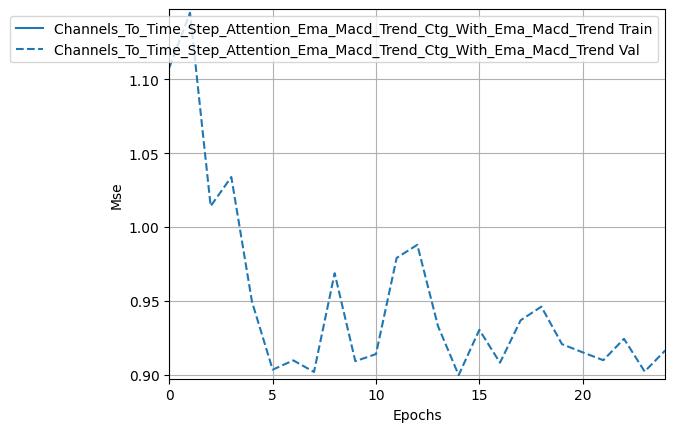

In [44]:
min_val_loss = df_result[tracking_loss_callback.val_loss_key].min()
max_val_loss = df_result[tracking_loss_callback.val_loss_key].max()
scale = (max_val_loss - min_val_loss) / 100
plotter = tfdocs.plots.HistoryPlotter(metric=metric_mse_name)
plotter.plot(size_histories)
plt.ylim([min_val_loss - scale, max_val_loss + scale])

(3.1968451499938966, 3.4867629051208495)

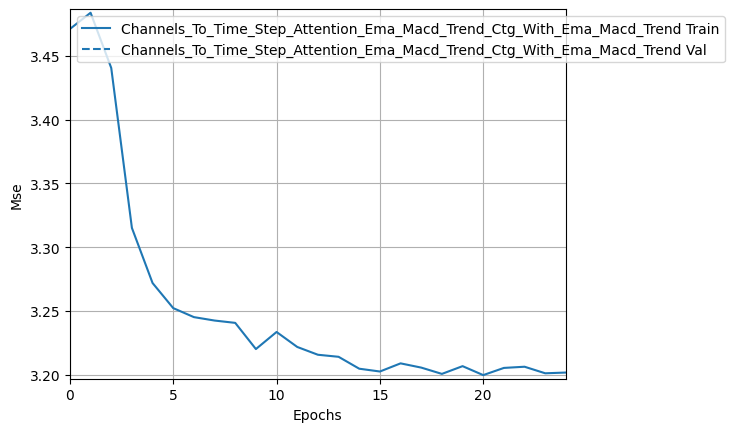

In [45]:
min_train_loss = df_result[tracking_loss_callback.train_loss_key].min()
max_train_loss = df_result[tracking_loss_callback.train_loss_key].max()
scale = (max_train_loss - min_train_loss) / 100
plotter = tfdocs.plots.HistoryPlotter(metric=metric_mse_name)
plotter.plot(size_histories)
plt.ylim([min_train_loss - scale, max_train_loss + scale])

In [46]:
# train_dataset = tf.data.Dataset.load(f'{dataset_folder}/train/next_3_day_up')
# test_dataset = tf.data.Dataset.load(f'{dataset_folder}/test/next_3_day_up')
# for x_train, y_train, date_train in train_dataset.take(2):
#     pass
# for x_test, y_test, date_test in test_dataset.take(2):
#     pass
# plt.imshow(x_train)
# y_train
# plt.imshow(x_test)
# y_test

In [47]:
list_name_models

['channels_to_time_step_attention_ema_macd_trend_epoch_20',
 'channels_to_time_step_attention_ema_macd_trend_epoch_21',
 'channels_to_time_step_attention_ema_macd_trend_epoch_22',
 'channels_to_time_step_attention_ema_macd_trend_epoch_23',
 'channels_to_time_step_attention_ema_macd_trend_epoch_24',
 'channels_to_time_step_attention_ema_macd_trend_epoch_15',
 'channels_to_time_step_attention_ema_macd_trend_epoch_14',
 'channels_to_time_step_attention_ema_macd_trend_epoch_13',
 'channels_to_time_step_attention_ema_macd_trend_epoch_12']

In [48]:
dataset_folder

'../dataset/ctg_with_ema_macd_trend'